**Outline**

The purpose of this script is to plot grand-average evokeds from the MNS_shortISI task

**Import packages**

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import ast
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import widgets
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


mne.set_log_level('ERROR')

**User input**

In [20]:
# Define task prefix
dataPre = 'MNS_shortISI'

# Source localization method
method_sufx = 'MNE-constrained'

# Sensor pick
pick = 'C3'

# Define colour palette (colorblind sensitive)
colors =  ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#CC79A7", "#9467BD"] 

# Font size for figures
fontsize = 12

**Define main directories and files**

In [3]:
# Main directories
projectDir = '../'
dataDir = os.path.join(projectDir, 'proc_data')
resultsDir = os.path.join(projectDir, 'results')
supportDir = os.path.join(projectDir, 'support_files')

# Input files
times_fname = os.path.join(resultsDir, f'{dataPre}-sens-evoked-times.npy')
info_fname = os.path.join(resultsDir, f'{dataPre}-sens-evoked-info.fif')
sens_data_fname =  os.path.join(resultsDir, 
								f'{dataPre}-trans-cleaned-manRej-baseCorrected-evoked-{pick}_N=11.npy')
label_data_fname = os.path.join(resultsDir, 
									f'{dataPre}-trans-cleaned-manRej-baseCorrected-{method_sufx}-labelEvoked_N=12.npy')

bfs_fname = os.path.join(resultsDir, f'{dataPre}_{pick}_and_label_evoked_stats.csv')
magns_fname = os.path.join(resultsDir, f'{dataPre}_{pick}_and_label_evoked_magnitudes.csv')


**Load and prepare the data for plotting**

In [4]:
# Load data
evoked_sens = np.load(sens_data_fname, allow_pickle=True)
evoked_labels = np.load(label_data_fname, allow_pickle=True)
bfs = pd.read_csv(bfs_fname)
magns = pd.read_csv(magns_fname)

times = np.load(times_fname, allow_pickle=True)
info = mne.io.read_info(info_fname)
ROIs = bfs['label'].unique()

print(f"times shape: {times.shape}")
print(f"sensor evoked data shape: {evoked_sens.shape}")
print(f"label evoked data shape: {evoked_labels.shape}")



times shape: (701,)
sensor evoked data shape: (11, 1, 701)
label evoked data shape: (12, 6, 701)


In [5]:
# Average evoked over subjects and compute standard errors
gavg_evoked_sens = np.mean(evoked_sens, axis=0).squeeze()
se_evoked_sens = (np.std(evoked_sens, axis=0) / np.sqrt(evoked_sens.shape[0])).squeeze()

gavg_evoked_labels = np.mean(evoked_labels, axis=0).squeeze()
se_evoked_labels = (np.std(evoked_labels, axis=0) / np.sqrt(evoked_labels.shape[0])).squeeze()

# Crop for plotting
crop_idxs = np.where((times >= -0.2) & (times <= 0.25))[0]
times_crop = times[crop_idxs]

gavg_evoked_sens_crop = gavg_evoked_sens[crop_idxs]
se_evoked_sens_crop = se_evoked_sens[crop_idxs]

gavg_evoked_labels_crop = gavg_evoked_labels[:, crop_idxs]
se_evoked_labels_crop = se_evoked_labels[:, crop_idxs]

print(times_crop.shape)
print(gavg_evoked_sens_crop.shape)

# Re-name columns in bfs and magns
bfs = bfs.rename(columns={'SEF20': 'N20m', 'SEF35': 'N35m', 'SEF60': 'N60m'})
magns = magns.rename(columns={'SEF20': 'N20m', 'SEF35': 'N35m', 'SEF60': 'N60m'})


# Convert bfs and magns to long format for easy plotting
bfs_long = pd.melt(bfs, id_vars=['label'], var_name='peak', value_name='bf')
# Drop na rows
bfs_long = bfs_long.dropna(subset=['bf'])

# Convert magns to long format
magns_long = pd.melt(magns, id_vars=['label'], var_name='peak')

# Split the 'value' column (which contains lists) into separate columns
split_values = magns_long['value'].str.split(',', expand=True)
magns_long = pd.concat([magns_long.drop(columns=['value']), split_values], axis=1)

# Wrangle back to long format
magns_long = magns_long.melt(id_vars=['label', 'peak'],  
											value_name='magnitude')

# Convert the 'magnitude' column to numeric
magns_long['magnitude'] = pd.to_numeric(magns_long['magnitude'], errors='coerce')

# drop na rows
magns_long = magns_long.dropna()

# Split into sensor and label data
bfs_long_sens = bfs_long[bfs_long['label'] == 'C3']
bfs_long_labels = bfs_long[bfs_long['label'] != 'C3']
magns_long_sens = magns_long[magns_long['label'] == 'C3']
magns_long_labels = magns_long[magns_long['label'] != 'C3']


(451,)
(451,)


**Plot the grand-average evoked response at C3**

Long thin version

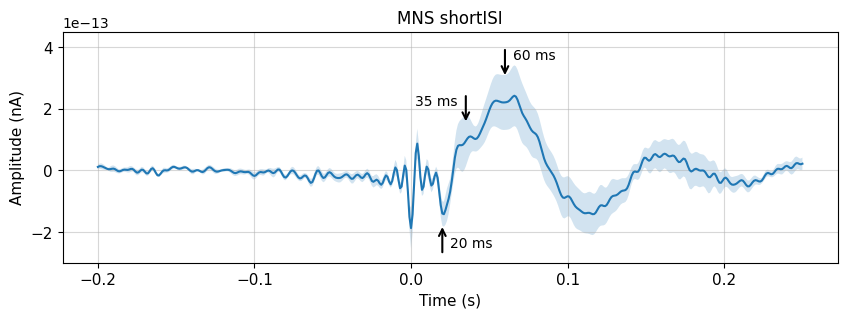

In [7]:
fig, ax = plt.subplots(1,1, figsize=(10,3))

plt.plot(times_crop, gavg_evoked_sens_crop, label=pick)
plt.fill_between(times_crop, gavg_evoked_sens_crop - se_evoked_sens_crop, 
				 gavg_evoked_sens_crop + se_evoked_sens_crop, 
				 alpha=0.2, label='SE')

plt.ylim(-3e-13, 4.5e-13)

# Add an arrow at 20 ms
plt.annotate('', xy=(0.02, -1.75e-13), xytext=(0.02, -2.75e-13),
			 arrowprops=dict(arrowstyle='->', lw=1.5, color='k'),
			 fontsize=12)
plt.annotate('20 ms', xy=(0.025, -1.5e-13), xytext=(0.025, -2.5e-13), ha='left')

# at 35 ms
plt.annotate('', xy=(0.035, 1.5e-13), xytext=(0.035, 2.5e-13),
			 arrowprops=dict(arrowstyle='->', lw=1.5, color='k'),
			 fontsize=12)
plt.annotate('35 ms', xy=(0.03, 2.1e-13), xytext=(0.03, 2.1e-13), ha ='right')

# 60 ms
plt.annotate('', xy=(0.06, 3e-13), xytext=(0.06, 4e-13),
			 arrowprops=dict(arrowstyle='->', lw=1.5, color='k'),
			 fontsize=12)
plt.annotate('60 ms', xy=(0.065, 3.6e-13), xytext=(0.065, 3.6e-13), ha='left')

# Show grid
plt.grid(alpha=0.5)


# Axis labels
plt.xlabel('Time (s)', fontsize=fontsize)
plt.ylabel('Amplitude (nA)', fontsize=fontsize)

# Title
plt.title('MNS shortISI')

# Set axis font size
plt.tick_params(axis='both', which='major', labelsize=fontsize)



plt.show()


**Plot grand-average at C3**

More square version

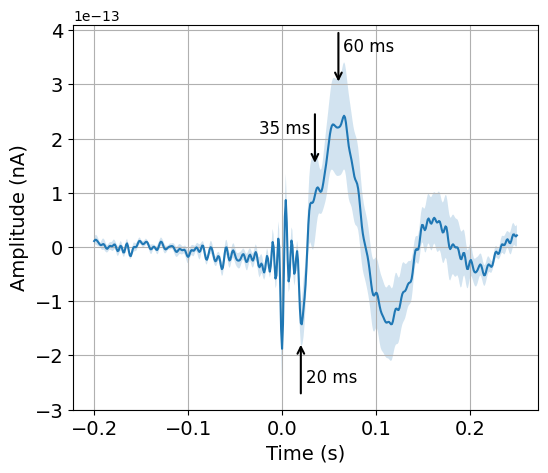

In [23]:
fig, ax = plt.subplots(1,1, figsize=(6,5))

plt.plot(times_crop, gavg_evoked_sens_crop, label=pick)
plt.fill_between(times_crop, gavg_evoked_sens_crop - se_evoked_sens_crop, 
				 gavg_evoked_sens_crop + se_evoked_sens_crop, 
				 alpha=0.2, label='SE')

plt.ylim(-3e-13, 4.1e-13)

# Add an arrow at 20 ms
plt.annotate('', xy=(0.02, -1.75e-13), xytext=(0.02, -2.75e-13),
			 arrowprops=dict(arrowstyle='->', lw=1.5, color='k'),
			 fontsize=fontsize)
plt.annotate('20 ms', xy=(0.025, -1.5e-13), xytext=(0.025, -2.5e-13), ha='left', fontsize=fontsize)

# at 35 ms
plt.annotate('', xy=(0.035, 1.5e-13), xytext=(0.035, 2.5e-13),
			 arrowprops=dict(arrowstyle='->', lw=1.5, color='k'),
			 fontsize=fontsize)
plt.annotate('35 ms', xy=(0.03, 2.1e-13), xytext=(0.03, 2.1e-13), ha ='right', fontsize=fontsize)

# 60 ms
plt.annotate('', xy=(0.06, 3e-13), xytext=(0.06, 4e-13),
			 arrowprops=dict(arrowstyle='->', lw=1.5, color='k'),
			 fontsize=fontsize)
plt.annotate('60 ms', xy=(0.065, 3.6e-13), xytext=(0.065, 3.6e-13), ha='left', fontsize=fontsize)

# Show grid
plt.grid()


# Axis labels
plt.xlabel('Time (s)', fontsize=fontsize+2)
plt.ylabel('Amplitude (nA)', fontsize=fontsize+2)
plt.xticks(fontsize=fontsize+2)
plt.yticks(fontsize=fontsize+2)

# Title
# plt.title(f'Grand-average SEF at sensor {pick}')


plt.show()


**Plot the grand-average response in labels**

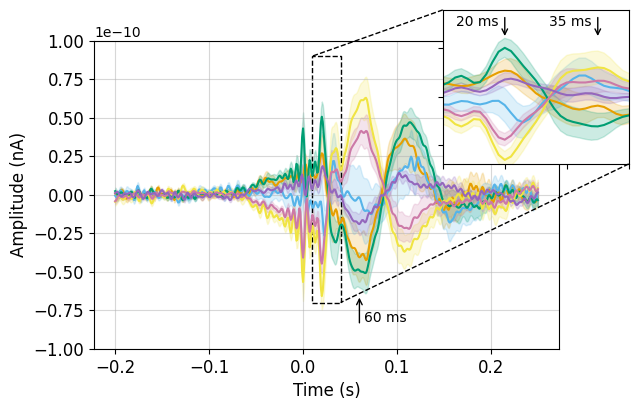

In [28]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

fontsize=10

# Define an inset axis to plot the zoomed-in region
axin = ax.inset_axes([0.75, 0.6, 0.4, 0.5], # [x0, y0, width, height]
					 facecolor='white')
axin.set_ylim(-0.7e-10, 0.9e-10)
axin.set_xlim(0.01, 0.04)

for i in range(0, gavg_evoked_labels_crop.shape[0]):
	# Plot the gavg data in the main axis
	ax.plot(times_crop, gavg_evoked_labels_crop[i,:], color=colors[i])
	ax.fill_between(times_crop, gavg_evoked_labels_crop[i,:] - se_evoked_labels_crop[i,:],
					 gavg_evoked_labels_crop[i,:] + se_evoked_labels_crop[i,:], 
					 alpha=0.2, color=colors[i])
	
	# Plot the zoomed-in data in the inset axis
	axin.plot(times_crop, gavg_evoked_labels_crop[i,:], color=colors[i])
	axin.fill_between(times_crop, gavg_evoked_labels_crop[i,:] - se_evoked_labels_crop[i,:],
					 gavg_evoked_labels_crop[i,:] + se_evoked_labels_crop[i,:], 
					 alpha=0.2, color=colors[i])
	
# Add arrows at 20 and 35 ms
axin.annotate('', xy=(0.02, 0.6e-10), xytext=(0.02, 0.85e-10),
			arrowprops=dict(arrowstyle='->', lw=1, color='black'),
			fontsize=fontsize, ha='center', va='center')
axin.text(0.019, 0.7e-10, '20 ms', fontsize=fontsize, ha='right', va='bottom')

axin.annotate('', xy=(0.035, 0.6e-10), xytext=(0.035, 0.85e-10),
			arrowprops=dict(arrowstyle='->', lw=1, color='black'),
			fontsize=fontsize, ha='center', va='center')
axin.text(0.034, 0.7e-10, '35 ms', fontsize=fontsize, ha='right', va='bottom')
	
# Remove axis ticks from the inset
axin.tick_params(labelleft=False, labelbottom=False)

# Mark the inset in the main plot
mark_inset(ax, axin, loc1=2, loc2=4, edgecolor="black", linestyle='--', linewidth=1)

# Add 60 ms arrow to main plot
ax.set_ylim(-1e-10, 1e-10)
ax.annotate('', xy=(0.06, -0.65e-10), xytext=(0.06, -0.85e-10),
			arrowprops=dict(arrowstyle='->', lw=1, color='black'),
			fontsize=fontsize, ha='center', va='center')
ax.text(0.065, -0.8e-10, '60 ms', fontsize=fontsize, ha='left', va='center')


# Axis labels
plt.xlabel('Time (s)', fontsize=fontsize+2)
plt.ylabel('Amplitude (nA)', fontsize=fontsize+2)
plt.tick_params(axis='both', which='major', labelsize=fontsize+2)

ax.grid(alpha=0.5)


**Plot label magntidues and BFS**


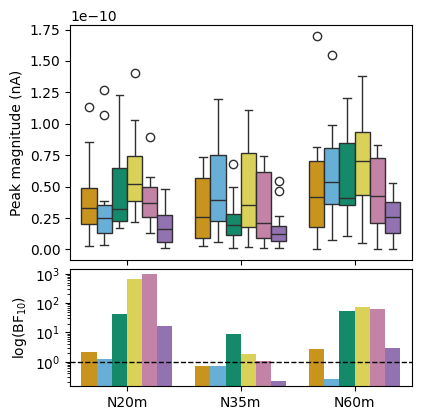

In [38]:
# Create a figure with 2 rows to plot the magnitudes and Bayes factors
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, sharex=True, figsize=(4,4))

# Plot the magnitudes
sns.boxplot(data=magns_long_labels, x='peak', y='magnitude', hue='label', palette=colors, showfliers=True, legend=False, ax=ax[0])
# sns.barplot(data=magns_long_labels, x='peak', y='magnitude', hue='label', errorbar='se',
# 			palette=colors, legend=False, ax=ax[0])

# Plot the Bayes factors
sns.barplot(data=bfs_long_labels,x='peak', y='bf', hue='label', palette=colors, legend=False, ax=ax[1])
ax[1].set_yscale('log')

# Add a line to denote BF = 1
ax[1].axhline(1, color='black', linestyle='--', lw=1)

# Axis labels
ax[0].set_ylabel('Peak magnitude (nA)', fontsize=fontsize)
ax[0].set_xlabel('')
ax[1].set_ylabel('log(BF$_{10}$)', fontsize=fontsize)
ax[1].set_xlabel('')

# Axis tick fontsize
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)


# Adjust layout
plt.tight_layout(pad=0)


In [ ]:
# Round values in bf to 2 decimal places
bfs['N20m'] = bfs['N20m'].round(2)
bfs['N35m'] = bfs['N35m'].round(2)
bfs['N60m'] = bfs['N60m'].round(2)

bfs